# **Imports** : *Exécuter*


**PATH à resneigner si non exécuté sur Google Colab !**

In [1]:
try :
  from google.colab import drive
  from google.colab import files
  drive.mount('/content/drive')
  PATH_GC = '/content/drive/My Drive' 
except Exception:
  print("Vous n'êtes pas sur Google Colab, vous êtes en local, assurez-vous d'avoir ajouter le Path du dossier Colab_sources")
  PATH_GC = './'#Emplacement du dossier /Colab_sources

Vous n'êtes pas sur Google Colab, vous êtes en local, assurez-vous d'avoir ajouter le Path du dossier Colab_sources


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
import os

#***Exécuter pour voir les performances***

In [3]:
l_algo=["FGSM", "PGD_Linf","PGD_Linf_random_restart","Square_attack_Linf"]
l_eps=[2/255,4/255,8/255,16/255]

In [4]:
def path(type,algo,eps):
  PATH = PATH_GC+'/Colab_sources/attacks/'
  return PATH+algo+'/'+algo+'_'+f'{eps}'+'_'+type+'_9555'+'.csv'

def evaluation(algo,eps,nb):
  labels=pd.read_csv(path("labels",algo,eps))
  return (labels["Labels data"][:nb]==labels["Labels data_attack"][:nb]).sum()/nb

def comparatif(n):
  form1 = "{0:<30}{1:<15}{2:<15}{3:<30}"
  form2 = "{0:<30}{1:<15}{2:<15.4f}{3:<30}"
  print(form1.format("Attack","epsilon","Accuracy","Sample test"))
  for algo in l_algo:
    print("")
    for eps in l_eps:
      print(form2.format(algo,f"{int(eps*255)}/255",evaluation(algo,int(eps*255),n),n))
  return

Choisir les ***n premières données*** à afficher dans *comparatif(**n**)*

*n in [0,9955]*


In [5]:
comparatif(1000)

Attack                        epsilon        Accuracy       Sample test                   

FGSM                          2/255          0.6400         1000                          
FGSM                          4/255          0.5490         1000                          
FGSM                          8/255          0.4500         1000                          
FGSM                          16/255         0.3070         1000                          

PGD_Linf                      2/255          0.3650         1000                          
PGD_Linf                      4/255          0.0240         1000                          
PGD_Linf                      8/255          0.0000         1000                          
PGD_Linf                      16/255         0.0000         1000                          

PGD_Linf_random_restart       2/255          0.3250         1000                          
PGD_Linf_random_restart       4/255          0.0160         1000                       

# **Réseau & Dataset** : *Exécuter*


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## **Réseau de neurones**

In [ ]:
## Extracted from https://github.com/SSAA3/stochastic-sparse-adv-attacks/blob/378f9ad8e6e3880482e7b15a2cdd5a60faffdfe4/data/train/ResNet18.py
#>>>>>>>>>>>>>>>>>>>

## Extracted from https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py

'''
ResNet in PyTorch.
For Pre-activation ResNet, see 'preact_resnet.py'.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
 Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
# Imports déjà effectués dans la section #**Imports**

# import torch
# import torch.nn as nn
# import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [ ]:
load_path = torch.load(PATH_GC+'/Colab_sources/lib/ResNet18_CIFAR10.pt', map_location=torch.device(device))
net = ResNet18()
net = torch.nn.DataParallel(net)
net.load_state_dict(load_path, strict=False)
net = net.eval()

## **Dataset**

In [ ]:
def load_CIRFA10(batch_size):

  PATH = PATH_GC+'/Colab_sources/data'
  resize = centercrop = 32
  transform_test = transforms.Compose([
            transforms.Resize(resize),
            transforms.CenterCrop(centercrop),
            transforms.ToTensor()])

  testset = torchvision.datasets.CIFAR10(root=PATH, train=False,
                                           download=False, transform=transform_test)
  testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, pin_memory=True,
                                             shuffle=False)

  classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
  return testloader, classes

In [ ]:
norm=transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010))

In [ ]:
batch_size=500

In [ ]:
testloader, classes = load_CIRFA10(batch_size)

In [ ]:
def new_testloader(model):
    l=[]
    n=0
    for _,(datas, labels) in enumerate(testloader):
        datas, labels=datas.to(device), labels.to(device)
        list_tf=(model(norm(datas)).max(dim=1)[1] == labels)
        n=n+list_tf.sum().item()
        l.append((datas[list_tf], labels[list_tf]))
    return n,l

In [ ]:
n_testloader2,testloader2=new_testloader(net)
print(n_testloader2)

9555


# **Paramètres attaques** : *Exécuter / Modifier à souhait*

In [ ]:
alpha = 4/255
num_iter = 15
num_restart = 3
n_iter = 15
p=0.8
loss_type="margin_loss"

# **Attaques** : *Exécuter*

## **Gradient**

### **FGSM**

In [ ]:
def fgsm_attack(model, data, label, epsilon):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(data, requires_grad=True)
    loss = F.nll_loss(model(norm(data + delta)), label)
    loss.backward()
    return torch.clamp(data+epsilon * delta.grad.detach().sign(), 0, 1)

### **PGD Linf**

In [ ]:
def pgd_linf(model, data, label, epsilon, alpha, num_iter):
    """ Construct PGD adversarial examples on the samples X"""
    delta = torch.zeros_like(data, requires_grad=True)
    for t in range(num_iter):
        loss = F.nll_loss(model(norm((data + delta).clamp(0, 1))), label)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()
                      ).clamp(-epsilon, epsilon)
        delta.grad.zero_()
    return (data+delta).clamp(0, 1).detach()

### **PGD Linf random restart**

In [ ]:
def pgd_linf_rand(model, data, label, epsilon, alpha, num_iter, restarts):
    """ Construct PGD adversarial examples on the samples X, with random restarts"""
    max_loss = torch.zeros(label.shape[0]).to(device)
    max_delta = torch.zeros_like(data)

    for i in range(restarts):
        delta = torch.rand_like(data, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon

        for t in range(num_iter):
            loss = F.nll_loss(model(norm((data + delta).clamp(0, 1))), label)
            loss.backward()
            delta.data = (delta + alpha*delta.grad.detach().sign()
                          ).clamp(-epsilon, epsilon)
            delta.grad.zero_()

        all_loss = nn.CrossEntropyLoss(
            reduction='none')(model(norm(data+delta)), label)
        max_delta[all_loss >= max_loss] = delta.detach()[all_loss >= max_loss]
        max_loss = torch.max(max_loss, all_loss)

    return (data + max_delta).clamp(0, 1).detach()

## **Square Attack**

### **Fonctions annexes**

In [ ]:
np.set_printoptions(precision=5, suppress=True)


def p_selection(p_init, it, n_iters):
    """ Piece-wise constant schedule for p (the fraction of pixels changed on every iteration). """
    it = int(it / n_iters * 10000)

    if 10 < it <= 50:
        p = p_init / 2
    elif 50 < it <= 200:
        p = p_init / 4
    elif 200 < it <= 500:
        p = p_init / 8
    elif 500 < it <= 1000:
        p = p_init / 16
    elif 1000 < it <= 2000:
        p = p_init / 32
    elif 2000 < it <= 4000:
        p = p_init / 64
    elif 4000 < it <= 6000:
        p = p_init / 128
    elif 6000 < it <= 8000:
        p = p_init / 256
    elif 8000 < it <= 10000:
        p = p_init / 512
    else:
        p = p_init

    return p


def pseudo_gaussian_pert_rectangles(x, y):
    delta = np.zeros([x, y])
    x_c, y_c = x // 2 + 1, y // 2 + 1

    counter2 = [x_c - 1, y_c - 1]
    for counter in range(0, max(x_c, y_c)):
        delta[max(counter2[0], 0):min(counter2[0] + (2 * counter + 1), x),
              max(0, counter2[1]):min(counter2[1] + (2 * counter + 1), y)] += 1.0 / (counter + 1) ** 2

        counter2[0] -= 1
        counter2[1] -= 1

    delta /= np.sqrt(np.sum(delta ** 2, keepdims=True))

    return delta


def meta_pseudo_gaussian_pert(s):
    delta = np.zeros([s, s])
    n_subsquares = 2
    if n_subsquares == 2:
        delta[:s // 2] = pseudo_gaussian_pert_rectangles(s // 2, s)
        delta[s // 2:] = pseudo_gaussian_pert_rectangles(s - s // 2, s) * (-1)
        delta /= np.sqrt(np.sum(delta ** 2, keepdims=True))
        if np.random.rand(1) > 0.5:
            delta = np.transpose(delta)

    elif n_subsquares == 4:
        delta[:s // 2, :s // 2] = pseudo_gaussian_pert_rectangles(
            s // 2, s // 2) * np.random.choice([-1, 1])
        delta[s // 2:, :s // 2] = pseudo_gaussian_pert_rectangles(
            s - s // 2, s // 2) * np.random.choice([-1, 1])
        delta[:s // 2, s // 2:] = pseudo_gaussian_pert_rectangles(
            s // 2, s - s // 2) * np.random.choice([-1, 1])
        delta[s // 2:, s // 2:] = pseudo_gaussian_pert_rectangles(
            s - s // 2, s - s // 2) * np.random.choice([-1, 1])
        delta /= np.sqrt(np.sum(delta ** 2, keepdims=True))

    return delta


def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)


def loss_f(label, res, loss_type="margin_loss"):
    """ Implements the margin loss (difference between the correct and 2nd best class). """
    if loss_type == "margin_loss":
        a = res-res[np.arange(label.shape[0]), label][:, None]
        a[np.arange(label.shape[0]), label] = np.inf
        return (-1*torch.min(a, dim=1)[0]).to('cpu').detach().numpy()
    else:
        return nn.CrossEntropyLoss(reduce=False)(res, label).to('cpu').detach().numpy()




### **L_inf**

In [ ]:
def square_attack_linf(model, data, label, eps, n_iters, p_init, loss_type):
    x = data.to('cpu').detach().numpy()
    y = label.to('cpu').detach().numpy()
    """ The Linf square attack """
    np.random.seed(0)  # important to leave it here as well
    min_val, max_val = 0, 1
    c, h, w = x.shape[1:]
    n_features = c*h*w

    # [c, 1, w], i.e. vertical stripes work best for untargeted attacks
    init_delta = np.random.choice([-eps, eps], size=[x.shape[0], c, 1, w])
    x_best = np.clip(x + init_delta, min_val, max_val)

    logits = model(norm(torch.tensor(x_best, dtype=torch.float32).to(device)))
    loss_min = loss_f(label, logits,  loss_type=loss_type)
    margin_min = loss_f(label, logits,  loss_type='margin_loss')
    # ones because we have already used 1 query
    n_queries = np.ones(x.shape[0])

    for i_iter in range(n_iters - 1):
        idx_to_fool = margin_min > 0
        x_curr, x_best_curr, y_curr = x[idx_to_fool], x_best[idx_to_fool], y[idx_to_fool]
        loss_min_curr, margin_min_curr = loss_min[idx_to_fool], margin_min[idx_to_fool]
        deltas = x_best_curr - x_curr

        p = p_selection(p_init, i_iter, n_iters)
        for i_img in range(x_best_curr.shape[0]):
            s = int(round(np.sqrt(p * n_features / c)))
            # at least c x 1 x 1 window is taken and at most c x h-1 x h-1
            s = min(max(s, 1), h-1)
            center_h = np.random.randint(0, h - s)
            center_w = np.random.randint(0, w - s)

            x_curr_window = x_curr[i_img, :,
                                   center_h:center_h+s, center_w:center_w+s]
            x_best_curr_window = x_best_curr[i_img, :,
                                             center_h:center_h+s, center_w:center_w+s]
            # prevent trying out a delta if it doesn't change x_curr (e.g. an overlapping patch)
            count=0
            while np.sum(np.abs(np.clip(x_curr_window + deltas[i_img, :, center_h:center_h+s, center_w:center_w+s], min_val, max_val) - x_best_curr_window) < 10**-7) == c*s*s:
                deltas[i_img, :, center_h:center_h+s, center_w:center_w +
                       s] = np.random.choice([-eps, eps], size=[c, 1, 1])
                count=count+1
                if count >10:
                    break

        x_new = np.clip(x_curr + deltas, min_val, max_val)

        logits = model(norm(torch.tensor(x_new, dtype=torch.float32).to(device)))

        loss = loss_f(torch.tensor(y_curr).to(device),
                      logits,  loss_type=loss_type)
        margin = loss_f(torch.tensor(y_curr).to(device),
                        logits,  loss_type='margin_loss')

        idx_improved = loss < loss_min_curr
        loss_min[idx_to_fool] = idx_improved * \
            loss + ~idx_improved * loss_min_curr
        margin_min[idx_to_fool] = idx_improved * \
            margin + ~idx_improved * margin_min_curr
        idx_improved = np.reshape(idx_improved, [-1, *[1]*len(x.shape[:-1])])
        x_best[idx_to_fool] = idx_improved * \
            x_new + ~idx_improved * x_best_curr
        n_queries[idx_to_fool] += 1

    return n_queries, torch.tensor(x_best, dtype=torch.float32).to(device)

# **Generation CSV** : *Modifier pour exécuter*

***n*** désigne le nombre de batch à exécuter

PS : la taille des batch est modifiale dans la section #Réseau & Dataset > Réseau > batch_size

PPS : une taille de batch élévée permet de tirer profit de GPU

### **FGSM**

In [ ]:
def generation_fgsm(model, eps,n):
    PATH = PATH_GC+'/Colab_sources/attacks/FGSM/'
    df_attacks=pd.DataFrame()
    df_labels=pd.DataFrame()
    print('{0:<22} {1:<}'.format("Start",f"{eps}"))
    n_handled=0

    for i,(datas, labels) in enumerate(testloader2):
        if i+1>n:
            break
        datas, labels=datas.to(device), labels.to(device)
        x_attack = fgsm_attack(model, datas, labels, eps)
        n_handled=n_handled+x_attack.shape[0]

        batch_in = pd.DataFrame(x_attack.view(datas.size()[0], -1).cpu().detach().numpy())
        df_attacks = df_attacks.append(batch_in)
        
        Labels =  pd.DataFrame({'Labels data' : labels.cpu().type(torch.int64).detach().numpy(), 
                          'Labels data_attack': (model(norm(x_attack)).max(dim=1)[1]).cpu().type(torch.int64).detach().numpy()})
        df_labels = df_labels.append(Labels)
        print('{0:<6} {1:<15}'.format(f"{n_handled}" ,"ème traité"))

    df_attacks.to_csv(os.path.join(PATH, f'FGSM_{int(eps*255)}_datas_attack_{n_handled}.csv'), index=False)
    df_labels.to_csv(os.path.join(PATH, f'FGSM_{int(eps*255)}_labels_{n_handled}.csv'), index=False)

    return ("End")

def generation_fgsm_eps(model, l_eps, n):
    for eps in l_eps:
        generation_fgsm(model,eps,n)
    return

In [ ]:
# generation_fgsm(net, 2/255,0)

In [ ]:
# generation_fgsm_eps(net, l_eps,np.infty)

### **PGD L_inf**

In [ ]:
def generation_pgd_l_inf(model, eps,n):
    PATH = PATH_GC+'/Colab_sources/attacks/PGD_Linf/'
    df_attacks=pd.DataFrame()
    df_labels=pd.DataFrame()
    print('{0:<22} {1:<}'.format("Start",f"{eps}"))
    n_handled=0

    for i,(datas, labels) in enumerate(testloader2):
        if i+1>n:
            break
        datas, labels=datas.to(device), labels.to(device)
        x_attack = pgd_linf(
            model, datas, labels, eps, alpha, num_iter)
        n_handled=n_handled+x_attack.shape[0]

        batch_in = pd.DataFrame(x_attack.view(datas.size()[0], -1).cpu().detach().numpy())
        df_attacks = df_attacks.append(batch_in)
        
        Labels =  pd.DataFrame({'Labels data' : labels.cpu().type(torch.int64).detach().numpy(), 
                          'Labels data_attack': (model(norm(x_attack)).max(dim=1)[1]).cpu().type(torch.int64).detach().numpy()})
        df_labels = df_labels.append(Labels)
        print('{0:<6} {1:<15}'.format(f"{n_handled}" ,"ème traité"))

    df_attacks.to_csv(os.path.join(PATH, f'PGD_Linf_{int(eps*255)}_datas_attack_{n_handled}.csv'), index=False)
    df_labels.to_csv(os.path.join(PATH, f'PGD_Linf_{int(eps*255)}_labels_{n_handled}.csv'), index=False)

    return ("End")

def generation_pgd_l_inf_eps(model, l_eps, n):
    for eps in l_eps:
        generation_pgd_l_inf(model,eps,n)
    return

In [ ]:
# generation_pgd_l_inf(net, 2/255,0)

In [ ]:
# generation_pgd_l_inf_eps(net, l_eps,np.infty)

### **PGD L_inf_random_restart**

In [ ]:
def generation_pgd_l_inf_random_restart(model, eps,n):
    PATH = PATH_GC+'/Colab_sources/attacks/PGD_Linf_random_restart/'
    df_attacks=pd.DataFrame()
    df_labels=pd.DataFrame()
    print('{0:<22} {1:<}'.format("Start",f"{eps}"))
    n_handled=0

    for i,(datas, labels) in enumerate(testloader2):
        if i+1>n:
            break
        datas, labels=datas.to(device), labels.to(device)
        x_attack = pgd_linf_rand(
            model, datas, labels, eps, alpha, num_iter, num_restart)
        n_handled=n_handled+x_attack.shape[0]

        batch_in = pd.DataFrame(x_attack.view(datas.size()[0], -1).cpu().detach().numpy())
        df_attacks = df_attacks.append(batch_in)
        
        Labels =  pd.DataFrame({'Labels data' : labels.cpu().type(torch.int64).detach().numpy(), 
                          'Labels data_attack': (model(norm(x_attack)).max(dim=1)[1]).cpu().type(torch.int64).detach().numpy()})
        df_labels = df_labels.append(Labels)
        print('{0:<6} {1:<15}'.format(f"{n_handled}" ,"ème traité"))

    df_attacks.to_csv(os.path.join(PATH, f'PGD_Linf_random_restart_{int(eps*255)}_datas_attack_{n_handled}.csv'), index=False)
    df_labels.to_csv(os.path.join(PATH, f'PGD_Linf_random_restart_{int(eps*255)}_labels_{n_handled}.csv'), index=False)

    return ("End")

def generation_pgd_l_inf_random_restart_eps(model, l_eps, n):
    for eps in l_eps:
        generation_pgd_l_inf_random_restart(model,eps,n)
    return

In [ ]:
# generation_pgd_l_inf_random_restart(net, 16/255,0)

In [ ]:
# generation_pgd_l_inf_random_restart_eps(net, l_eps,np.infty)

### **Square_attack_L_inf**

In [ ]:
def generation_square_attacks_l_inf(model, eps,n):
    PATH = PATH_GC+'/Colab_sources/attacks/Square_attack_Linf/'
    df_attacks=pd.DataFrame()
    df_labels=pd.DataFrame()
    print('{0:<22} {1:<}'.format("Start",f"{eps}"))
    n_handled=0

    for i,(datas, labels) in enumerate(testloader2):
        if i+1>n:
            break
        datas, labels=datas.to(device), labels.to(device)
        _, x_attack = square_attack_linf(
            model, datas, labels, eps, n_iter, p, loss_type)
        n_handled=n_handled+x_attack.shape[0]

        batch_in = pd.DataFrame(x_attack.view(datas.size()[0], -1).cpu().detach().numpy())
        df_attacks = df_attacks.append(batch_in)
        
        Labels =  pd.DataFrame({'Labels data' : labels.cpu().type(torch.int64).detach().numpy(), 
                          'Labels data_attack': (model(norm(x_attack)).max(dim=1)[1]).cpu().type(torch.int64).detach().numpy()})
        df_labels = df_labels.append(Labels)
        print('{0:<6} {1:<15}'.format(f"{n_handled}" ,"ème traité"))

    df_attacks.to_csv(os.path.join(PATH, f'Square_attack_Linf_{int(eps*255)}_datas_attack_{n_handled}.csv'), index=False)
    df_labels.to_csv(os.path.join(PATH, f'Square_attack_Linf_{int(eps*255)}_labels_{n_handled}.csv'), index=False)

    return ("End")

def generation_square_attack_l_inf_eps(model, l_eps, n):
    for eps in l_eps:
        generation_square_attacks_l_inf(model,eps,n)
    return

In [ ]:
# generation_square_attacks_l_inf(net, 2/255,0)

In [ ]:
# generation_square_attack_l_inf_eps(net, l_eps,np.infty)

# **Performances (génération et calcul sans sauvegarde)** : *Modifier pour exécuter*

## **Performance réseau de neuronnes**

In [ ]:
def performance(batch_size, model,testloader):
    n_attack = 0
    n_handled=0
    print('{0:<22} {1:<}'.format("Image handeled","Accuracy of the neural network"))
    for i,(datas, labels) in enumerate(testloader):
        datas, labels=datas.to(device), labels.to(device)
        n_attack = n_attack + \
            (model(norm(datas)).max(dim=1)[1] != labels).sum().item()
        n_handled=n_handled+datas.shape[0]
        if i==0:
            print('{:^45}'.format("Start !"))
        if (n_handled % 100 == 0) and n_handled > 0:
            print('{0:<6} {1:<15} {2:<10}'.format(f"{(i+1)*batch_size}" ,"ème traité",f"{100*(1-n_attack/((i+1)*batch_size))}"))
    return 1-n_attack/n_testloader2

In [ ]:
performance(batch_size,net,testloader)

Accuracy ResNet18 : 95.55%

In [ ]:
performance(batch_size,net,testloader2)

## **Attaques PGD**

### **FGSM**

In [ ]:
def performance_fgsm(model, eps):
    n_attack = 0
    n_handled=0
    print('{0:<22} {1:<}'.format("Image handeled","Accuracy of the neural network"))
    for i,(datas, labels) in enumerate(testloader2):
        datas, labels=datas.to(device), labels.to(device)
        x_attack = fgsm_attack(model, datas, labels, eps)
        n_attack = n_attack + \
            (model(norm(x_attack)).max(dim=1)[1] != labels).sum().item()
        n_handled=n_handled+datas.shape[0]
        if i==0:
            print('{:^45}'.format("Start !"))
        if (n_handled % 100 == 0) and n_handled>0:
            print('{0:<6} {1:<15} {2:<10}'.format(f"{n_handled}" ,"ème traité",f"{100*(1-n_attack/n_handled)}"))
    return 1-n_attack/n_testloader2

def performance_fgsm_eps(model, l_eps):
    l=[]
    print("Accuracy")
    for eps in l_eps:
        n_attack = 0
        for _,(datas, labels) in enumerate(testloader2):
            datas, labels=datas.to(device), labels.to(device)
            x_attack = fgsm_attack(model, datas, labels, eps)
            n_attack = n_attack + \
                (model(norm(x_attack)).max(dim=1)[1] != labels).sum().item()
        l.append((eps,1-n_attack/n_testloader2))
        print(f"{l[-1]} - ok !")
    return l

In [ ]:
performance_fgsm(net, 2/255)

In [ ]:
performance_fgsm_eps(net, l_eps)

### **PGD l_inf**

In [ ]:
def performance_pgd_linf(model, eps, alpha, num_iter):
    n_attack = 0
    n_handled=0
    print('{0:<22} {1:<}'.format("Image handeled","Accuracy of the neural network"))
    for i, (datas, labels) in enumerate(testloader2):
        datas, labels=datas.to(device), labels.to(device)
        x_attack = pgd_linf(
            model, datas, labels, eps, alpha, num_iter)
        n_attack = n_attack + \
            (model(norm(x_attack)).max(dim=1)[1] != labels).sum().item()
        n_handled=n_handled+datas.shape[0]
        if i==0:
            print('{:^45}'.format("Start !"))
        if (n_handled % 100 == 0) and n_handled>0:
            print('{0:<6} {1:<15} {2:<10}'.format(f"{n_handled}" ,"ème traité",f"{100*(1-n_attack/n_handled)}"))
    return 1-n_attack/n_testloader2

def performance_pgd_linf_eps(model, l_eps, num_iter):
    l=[]
    for eps in l_eps:
        l.append((eps,performance_pgd_linf(net, eps, alpha, num_iter)))
    return l

In [ ]:
performance_pgd_linf(net, 2/255, alpha, 15)

In [ ]:
performance_pgd_linf_eps(net, l_eps, 15)

### **PGD l_inf random**

In [ ]:
def performance_pgd_linf_rand(model, eps, alpha, num_iter,num_restart):
    n_attack = 0
    n_handled=0
    print('{0:<22} {1:<}'.format("Image handeled","Accuracy of the neural network"))
    for i, (datas, labels) in enumerate(testloader2):
        datas, labels=datas.to(device), labels.to(device)
        x_attack = pgd_linf_rand(
            model, datas, labels, eps, alpha, num_iter, num_restart)
        n_attack = n_attack + \
            (model(norm(x_attack)).max(dim=1)[1] != labels).sum().item()
        n_handled=n_handled+datas.shape[0]
        if i==0:
            print('{:^45}'.format("Start !"))
        if (n_handled % 100 == 0) and n_handled>0:
            print('{0:<6} {1:<15} {2:<10}'.format(f"{n_handled}" ,"ème traité",f"{100*(1-n_attack/n_handled)}"))
    return 1-n_attack/n_testloader2

def performance_pgd_linf_rand_eps(model, l_eps, num_iter,num_restart):
    l=[]
    for eps in l_eps:
        alpha=eps/10
        l.append((eps,performance_pgd_linf_rand(model, eps, alpha, num_iter,num_restart)))
    return l

In [ ]:
performance_pgd_linf_rand(net, 16/255, alpha, 15,3)

In [ ]:
performance_pgd_linf_rand_eps(batch_size, net, l_eps,15,3)

## **Square attacks**

### **L_inf**

In [ ]:
def performance_square_attack_linf(model, eps, n_iter, p, loss_type):
    n_attack = 0
    n_handled = 0
    print('{0:<22} {1:<}'.format("Image handeled","Accuracy of the neural network"))
    for i, (datas, labels) in enumerate(testloader2):
        datas, labels = datas.to(device), labels.to(device)
        _, x_square_attack = square_attack_linf(
            model, datas, labels, eps, n_iter, p, loss_type)
        n_attack = n_attack + \
            (model(norm(x_square_attack)).max(dim=1)[1] != labels).sum().item()
        n_handled = n_handled + datas.shape[0]
        if i==0:
            print('{:^45}'.format("Start !"))
        if (n_handled % 100 == 0) and n_handled >0:
            print('{0:<6} {1:<15} {2:<10}'.format(f"{n_handled}" ,"ème traité",f"{100*(1-n_attack/n_handled)}"))
    return 1-n_attack/n_testloader2

def performance_square_attack_linf_eps(model, l_eps, n_iter, p, loss_type):
    l=[]
    for eps in l_eps:
        l.append((eps,performance_square_attack_linf(model, eps, n_iter, p, loss_type)))
    return l

In [ ]:
performance_square_attack_linf(net, 16/255, 15, 0.8, "margin_loss")

In [ ]:
performance_square_attack_linf_eps(net, l_eps, 15, 0.8, "margin_loss")

# **Visualisation** : *Modifier pour exécuter*

### ***Data***

In [ ]:
def unnormalize(img):
    return np.clip(img.copy(),0,1)

def show_tensor(data):
    plt.imshow(unnormalize(
        data.squeeze().to('cpu').detach().numpy()).transpose((1, 2, 0)))
    plt.axis('off')
    plt.savefig("image.png")
    return plt.show()

def extraction(algo,eps,i):
  df_datas=datas=pd.read_csv(path("datas_attack",algo,eps))
  df_data=df_datas.iloc[i,:]
  return torch.tensor(df_data.values).view(1,3,32,32)


In [ ]:
show_tensor(extraction("Square_attack_Linf",16,10))

### **PGD(alpha)**

In [ ]:
def visualisation_PGD_alpha(model, data, label, l_epsilon, l_alpha, num_iter):
    for epsilon in l_epsilon : 
        l_data_attack = []
        for i in l_alpha:
            alpha=epsilon/i
            data_attack = pgd_linf(
              model, data, label, epsilon, alpha, num_iter)
            l_data_attack.append(F.nll_loss(
              model(norm(data_attack)), label).item())

        plt.plot([i for i in range(1,len(l_alpha)+1)], l_data_attack)
    plt.xlabel("α*255")
    plt.ylabel("Null loss")
    plt.legend([str(int(i*255))+"/255" for i in l_epsilon],title="ε")
    plt.title(f"{batch_size} images")
    plt.savefig("image.png")
    return plt.show()

In [ ]:
datas,labels=testloader2[1]
dats,labels=data.to(device),label.to(device)
visualisation_PGD_alpha(net, datas, labels, l_eps,
                            [i for i in range(1, 30)], 15)

In [ ]:
files.download("image.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **PGD(num_iter)**

In [ ]:
def visualisation_PGD_num_iter(model, data, label, l_epsilon, alpha, l_num_iter):
    for epsilon in l_epsilon : 
        l_data_attack = []
        for num_iter in l_num_iter:
            data_attack = pgd_linf(
              model, data, label, epsilon, alpha, num_iter)
            l_data_attack.append(F.nll_loss(
              model(norm(data_attack)), label).item())

        plt.plot(l_num_iter, l_data_attack)
    plt.xlabel("Itérations")
    plt.ylabel("Null loss")
    plt.legend([str(int(i*255))+"/255" for i in l_epsilon],title="ε")
    plt.title(f"{batch_size} images")
    plt.savefig("image.png")
    return plt.show()

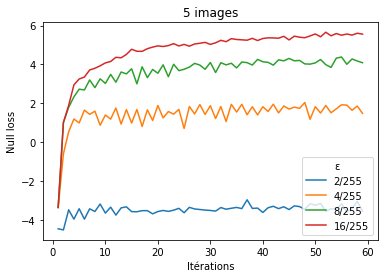

In [ ]:
datas,labels=testloader2[1]
dats,labels=data.to(device),label.to(device)
visualisation_PGD_num_iter(net, data, label, l_eps, 4/(255), [
        i for i in range(1, 60)])

In [ ]:
files.download("image.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Square attack**

In [ ]:
def visualisation_square_attack_num_iter(model, data, label, l_num_iter):
    l_data_attack = []
    for num_iter in l_num_iter:
        _, data_attack = square_attack_linf(
            net, data, label, 16/255, num_iter, 0.8, "margin_loss")
        l_data_attack.append(F.nll_loss(
            model(norm(data_attack)), label).item())

    plt.plot(l_num_iter, l_data_attack)
    plt.xlabel("Number of iterations")
    plt.ylabel("Null loss")
    plt.suptitle(
        f"Square Attack Linf - {batch_size} images")
    plt.savefig("image.png")
    return plt.show()

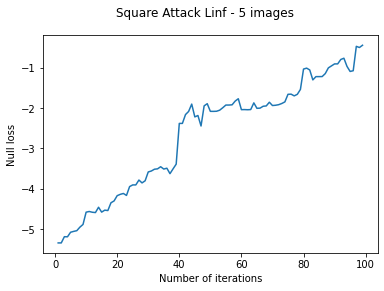

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
visualisation_square_attack_num_iter(net, data, label, range(1,100))
files.download("image.png")